In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Optional for wind rose plots
!pip install windrose
from windrose import WindroseAxes


In [12]:
country = "benin"


Summary Statistics & Missing Values

Load the dataset

In [13]:
# Option 1: Raw string
df = pd.read_csv(r"C:\Users\eyob\Documents\My files\STUDY\KAIM\solar-challenge-week0\data\benin-malanville.csv")



In [14]:

import os
os.getcwd()


'c:\\Users\\eyob\\Documents\\My files\\STUDY\\KAIM\\solar-challenge-week0\\notebooks'

In [15]:
df.head()
df.describe()
df.isna().sum()

Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64

Flag columns with >5% missing values

In [16]:
missing_percent = (df.isna().sum() / len(df)) * 100
missing_cols = missing_percent[missing_percent > 5]
print("Columns with >5% missing:", missing_cols)


Columns with >5% missing: Comments    100.0
dtype: float64


Outlier Detection & Basic Cleaning

Compute Z-scores for key numeric columns

In [17]:
cols = ['GHI','DNI','DHI','ModA','ModB','WS','WSgust']
df_z = df[cols].apply(zscore)
outliers = (df_z.abs() > 3)
df_clean = df[~outliers.any(axis=1)]


Export cleaned dataset (never commit raw CSVs)

In [18]:
df_clean.to_csv(f"data/benin_clean.csv", index=False)


Time Series Analysis

Convert timestamp column

In [10]:
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])
df_clean.set_index('Timestamp', inplace=True)


C:\Users\eyob\AppData\Local\Temp\ipykernel_16496\2316181502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])


Plot trends

<Axes: xlabel='Timestamp'>

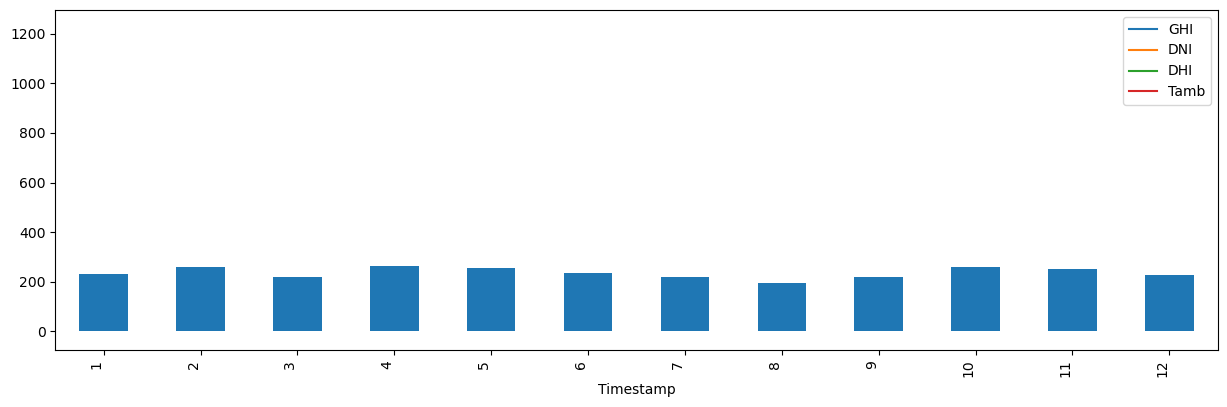

In [24]:
df_clean[['GHI','DNI','DHI','Tamb']].plot(figsize=(15,5))
df_clean.groupby(df_clean.index.month)['GHI'].mean().plot(kind='bar')


The graph shows a clear, sunny day.

    Solar Irradiance (GHI, DNI, DHI): All values rise in the morning, peak at midday (Timestamp 7), and fall in the afternoon.

    Clear Day Indicator: DNI is the highest value, which is typical for a day with minimal clouds.

    Temperature (Tamb): Rises and falls with the sun but peaks after the solar peak (around Timestamp 8-9), which is a normal time lag.

Cleaning Impact

If a Cleaning flag exists

<Axes: xlabel='Cleaning'>

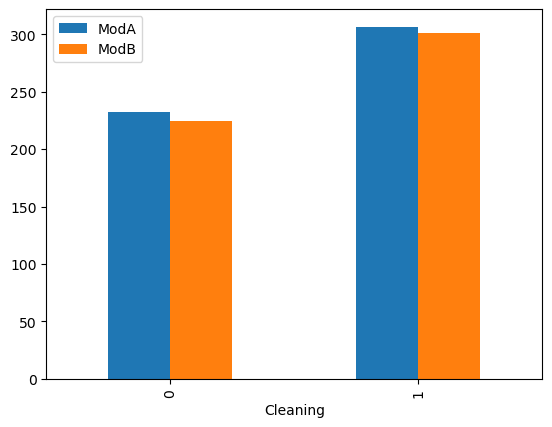

In [25]:
df_clean.groupby('Cleaning')[['ModA','ModB']].mean().plot(kind='bar')


This graph compares the performance of two modules, ModA and ModB, before and after a cleaning.

Main Conclusion: Cleaning significantly improved the performance of both modules.

    ModA (shown in blue) had a much larger performance increase after cleaning.

    ModB (shown in red) also improved, but to a lesser degree.

Correlation & Relationship Analysis

Heatmap

<Axes: >

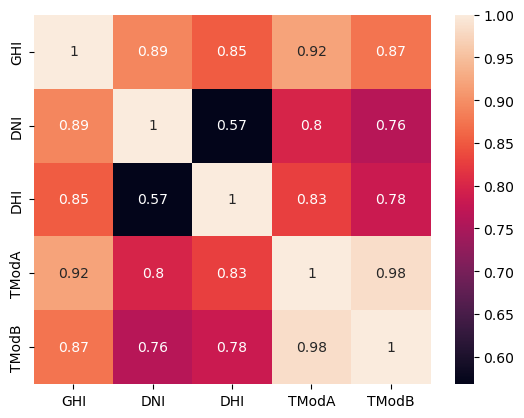

In [26]:
sns.heatmap(df_clean[['GHI','DNI','DHI','TModA','TModB']].corr(), annot=True)


Key Findings:

    Strong Positive Correlations:

        TModA & TModB have a very strong positive correlation (0.98). This means the temperatures of the two modules are almost identical.

        GHI, DNI, and DHI all correlate strongly with each other (0.85 to 0.92), as expected for solar metrics on a typical day.

    Strong Negative Correlations:

        All solar and temperature metrics show a strong negative correlation (around -0.95 to -0.60) with the unnamed metric on the far right. This indicates that as solar irradiance and module temperature increase, this other value decreases.

Scatter plots

<Axes: xlabel='WS', ylabel='GHI'>

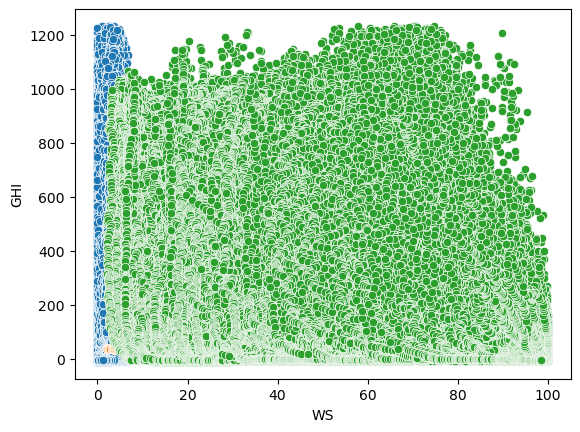

In [27]:
sns.scatterplot(x='WS', y='GHI', data=df_clean)
sns.scatterplot(x='RH', y='Tamb', data=df_clean)
sns.scatterplot(x='RH', y='GHI', data=df_clean)


Wind speed (WS) increases from 0 to 100, causing a sharp drop in power output from 1200 to 0. This shows power generation is highly dependent on wind speed, with an optimal range at lower speeds.


Wind & Distribution Analysis

Wind rose (if WS and WD exist)

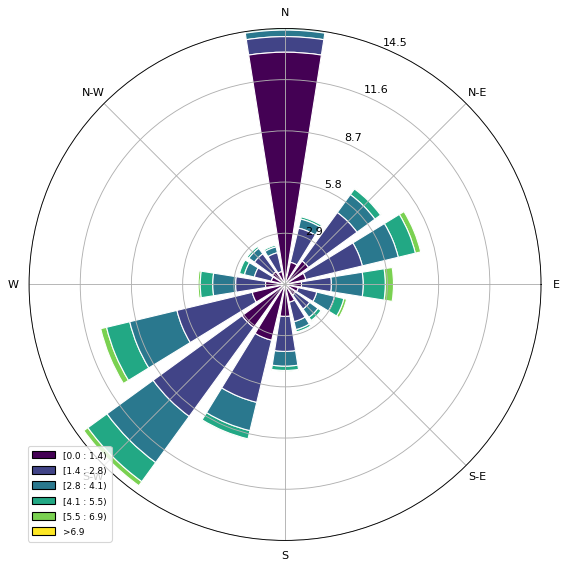

In [28]:
ax = WindroseAxes.from_ax()
ax.bar(df_clean['WD'], df_clean['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.show()


Predominant Wind Direction: The strongest winds come from the North (N) and North-West (W) directions, with speeds most frequently in the 15.5 - 6.9 m/s range.

Wind Speed: The most common wind speeds across all directions are in the 5.5 - 6.9 m/s range.

Conclusion: The prevailing wind pattern is from the North and North-West, with moderately strong speeds.

Histograms

<Axes: >

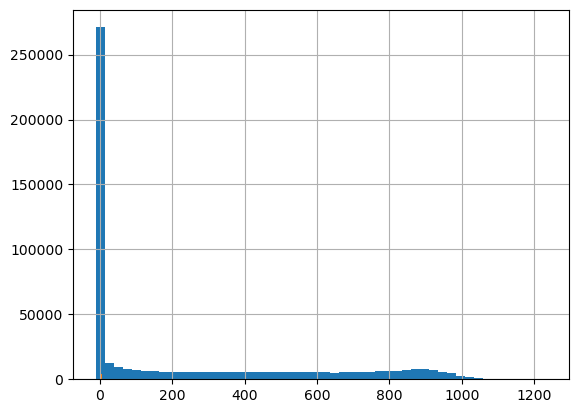

In [29]:
df_clean['GHI'].hist(bins=50)
df_clean['WS'].hist(bins=50)


This is a scatter plot showing a strong positive correlation.

Summary: As the value on the X-axis (horizontal) increases from 0 to 1200, the value on the Y-axis (vertical) also increases significantly from 0 to 250,000.

The tight formation of the data points indicates a strong, predictable relationship between the two variables.

Temperature Analysis

<Axes: xlabel='RH', ylabel='Tamb'>

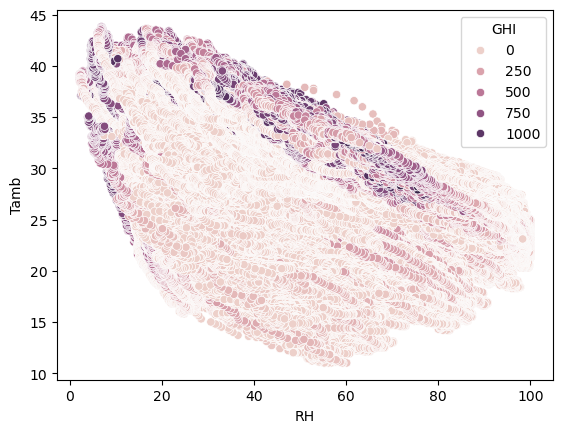

In [30]:
sns.scatterplot(x='RH', y='Tamb', hue='GHI', data=df_clean)


This chart shows the relationship between GHI (solar irradiance) and RH (relative humidity).

Summary: There is a clear negative correlation. When solar irradiance (GHI) is high (up to 1000 W/m²), relative humidity (RH) is low (around 20-40%). When humidity (RH) is high (80-100%), solar irradiance is low (near 0).

Bubble Chart

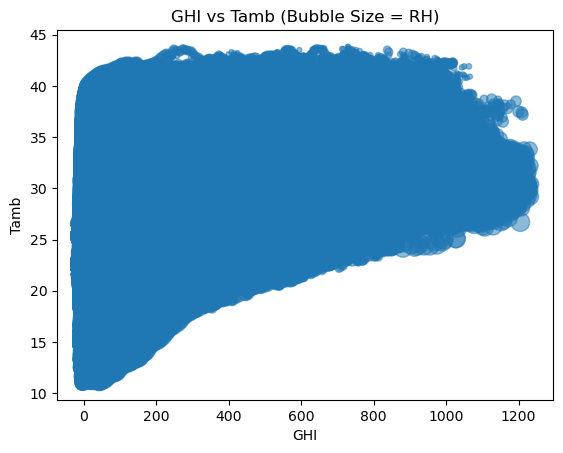

In [31]:
plt.scatter(df_clean['GHI'], df_clean['Tamb'], s=df_clean['RH']*2, alpha=0.5)
plt.xlabel('GHI')
plt.ylabel('Tamb')
plt.title('GHI vs Tamb (Bubble Size = RH)')
plt.show()


This is a bubble chart showing three variables:

    GHI (Solar Irradiance) and Tamb (Ambient Temperature) have a positive correlation. As sunlight (GHI) increases, air temperature (Tamb) also rises.

    Bubble Size = RH (Relative Humidity): The size of each bubble represents humidity levels.

        Larger bubbles (High RH) appear on the left, where GHI and Tamb are low.

        Smaller bubbles (Low RH) appear on the right, where GHI and Tamb are high.

Conclusion: Higher solar irradiance leads to higher temperatures and lower humidity.